# TDL 5.2 Thinking with Deep Learning: Week 5 Part 2
# Deep Learning with Knowledge Graphs, Tabular, and Categorical Data

__Instructor:__ James Evans

__Teaching Assistants & Content Creators/Organisers:__ Bhargav Srinivasa Desikan (Notebook Author), Likun Cao (Notebook Reviewer)

In this notebook, we will be exploring different neural network models for tabular and categorical data, as well as for knowledge graphs.

# Deep Neural Models for Tabular and Categorical Data

Note: you might have seen this network in our week2 tutorials - it is reintroduced here as these kind of networks are especially suited for this kind of data. If you didn't use it then, we recommend you try it now!

Another network you have already seen in the last chapter, a deep feed forward network is one where we have (usually) more than 2 layers of nodes which are fully connected. The crucial distinction here is that while a shallow network could get away with not needing to backpropagate values through the network, a deep network must crucially be able to do this. It is with the Stochastic Gradient Descent powered backpropagation of values that we are able to change our weights and make DNNs useful, and since then, different kinds of DNNs have been the state of the art. 

The last time we saw deep neural models, we added a single layer to our shallow network (refer to [tut 1.2](https://colab.research.google.com/drive/18NT8eyzhlDN9h-lb6svRsbxJ6r3tPNRU?usp=sharing). In this section, we will try different variations of deeo models, and use the example in the Keras documentation, *Structured data learning with Wide, Deep, and Cross networks* ([Keras - Salama, 2020](https://keras.io/examples/structured_data/wide_deep_cross_networks/)). 

**IMPORTANT NOTE**: this sort of model includes many new topics, so you may not understand every aspect of this model right away. What is important to get from this example, however, is the kind of data we are feeding into the model, the parameters of the model, and the task. In this case, the setting is diverse dataset of forest cover type, using both numerical features and categorical features, and predicting a label over multiple classes. You will often find such scenarios in social sciences datasets, such as census data. Notice the way the data is set up, and the parts of the neural network - the loss function, activation functions, optimisers, and so on. 

This example demonstrates how to do structured data classification using the 
two modeling
techniques. It is highly recommended to skim these two articles before diving in! The description below the model is the abstract. 

1. [Wide & Deep](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) models

- The human brain is a sophisticated learning machine, forming rules by memorizing everyday events (“sparrows can fly” and “pigeons can fly”) and generalizing those learnings to apply to things we haven't seen before (“animals with wings can fly”). Perhaps more powerfully, memorization also allows us to further refine our generalized rules with exceptions (“penguins can't fly”). As we were exploring how to advance machine intelligence, we asked ourselves the question—can we teach computers to learn like humans do, by combining the power of memorization and generalization? It's not an easy question to answer, but by jointly training a wide linear model (for memorization) alongside a deep neural network (for generalization), one can combine the strengths of both to bring us one step closer. At Google, we call it Wide & Deep Learning. It's useful for generic large-scale regression and classification problems with sparse inputs (categorical features with a large number of possible feature values), such as recommender systems, search, and ranking problems.

2. [Deep & Cross](https://arxiv.org/abs/1708.05123) models - 

- Feature engineering has been the key to the success of many prediction models. However, the process is nontrivial and often requires manual feature engineering or exhaustive searching. DNNs
are able to automatically learn feature interactions; however, they
generate all interactions implicitly, and are not necessarily efficient in learning all types of cross features. In this paper, we propose the Deep & Cross Network (DCN) which keeps the benefits of
a DNN model, and beyond that, it introduces a novel cross network
more efficient in learning certain bounded-degree feature
interactions. In particular, DCN explicitly applies feature crossing
at each layer, requires no manual feature engineering, and adds
negligible extra complexity to the DNN model. Our experimental
results have demonstrated its superiority over the state-of-art algorithms on the CTR prediction dataset and dense classification
dataset, in terms of both model accuracy and memory usage.


### The dataset

This example uses the [Covertype](https://archive.ics.uci.edu/ml/datasets/covertype) dataset from the UCI
Machine Learning Repository. The task is to predict forest cover type from cartographic variables.
The dataset includes 506,011 instances with 12 input features: 10 numerical features and 2
categorical features. Each instance is categorized into 1 of 7 classes, and is **multilabel classification task**. Even though the dataset isn't social scientific, it combines both numerical values and categorical features, which is something you might be dealing with often.

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Prepare the data

First, let's load the dataset from the UCI Machine Learning Repository into a Pandas
DataFrame:

In [ ]:
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
raw_data = pd.read_csv(data_url, header=None)
print(f"Dataset shape: {raw_data.shape}")
raw_data.head()

Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


The two categorical features in the dataset are binary-encoded.
We will convert this dataset representation to the typical representation, where each
categorical feature is represented as a single integer value.

In [ ]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape}")
data.head().T

Dataset shape: (581012, 13)


,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


The shape of the DataFrame shows there are 13 columns per sample
(12 for the features and 1 for the target label).

Let's split the data into training (85%) and test (15%) sets.

In [ ]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 493979
Test split size: 87033


Next, store the training and test data in separate CSV files.

In [ ]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

### Define dataset metadata

Here, we define the metadata of the dataset that will be useful for reading and parsing
the data into input features, and encoding the input features with respect to their types.

In [ ]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

### Experiment setup

Next, let's define an input function that reads and parses the file, then converts features
and labels into a[`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets)
for training or evaluation.

In [ ]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()


Here we configure the parameters and implement the procedure for running a training and
evaluation experiment given a model. Note the optimizer (and learning rate), loss, metrics. The rest of the code just sets up the training and testing parts of the dataset, fits and evaluates it.

In [ ]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


### Create model inputs

Now, define the inputs for the models as a dictionary, where the key is the feature name,
and the value is a `keras.layers.Input` tensor with the corresponding feature shape
and data type.

In [ ]:

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


### Encode features

We create two representations of our input features: sparse and dense:
1. In the **sparse** representation, the categorical features are encoded with one-hot
encoding using the `CategoryEncoding` layer. This representation can be useful for the
model to *memorize* particular feature values to make certain predictions.
2. In the **dense** representation, the categorical features are encoded with
low-dimensional embeddings using the `Embedding` layer. This representation helps
the model to *generalize* well to unseen feature combinations.

In [ ]:

from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            index = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = index(inputs[feature_name])
            if use_embedding:
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding_ecoder = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding_ecoder(value_index)
            else:
                # Create a one-hot encoder.
                onehot_encoder = CategoryEncoding(output_mode="binary")
                onehot_encoder.adapt(index(vocabulary))
                # Convert the index values to a one-hot representation.
                encoded_feature = onehot_encoder(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features


### Experiment 1: a baseline model

In the first experiment, let's create a multi-layer feed-forward network,
where the categorical features are one-hot encoded. 

**Note**: Some new terms here! We see a Batch Normalisation layer. We will encounter these in our second notebook on regularisation, but for a brief explanation:

Batch normalization tries to reduce the “internal covariate shift” between training and testing data. Internal covariate shift is the change in the distribution of network activations due to the change in paramaters during training. In neural networks, the output of the first layer feeds into the second layer, the output of the second layer feeds into the third, and so on. When the parameters of a layer change, so does the distribution of inputs to subsequent layers. These shifts in input distributions can be problematic for neural networks, especially deep neural networks that could have a large number of layers. Batch normalization tries to mitigate this. You can check out [this](https://arxiv.org/abs/1502.03167) paper where the idea of mitigating internal covariance shift with batch normalization was first introduced. 

We also see Dropout, another term from the regularisation universe. Dropout involves injecting noise while computing each internal layer during forward propagation. The method is called dropout because we literally drop out some neurons during training. Throughout training, on each iteration, standard dropout consists of zeroing out some fraction of the nodes in each layer before calculating the subsequent layer.

![Dropout](https://d2l.ai/_images/dropout2.svg)


**We will revisit these topics, but in PyTorch, and in the next tutorial.**


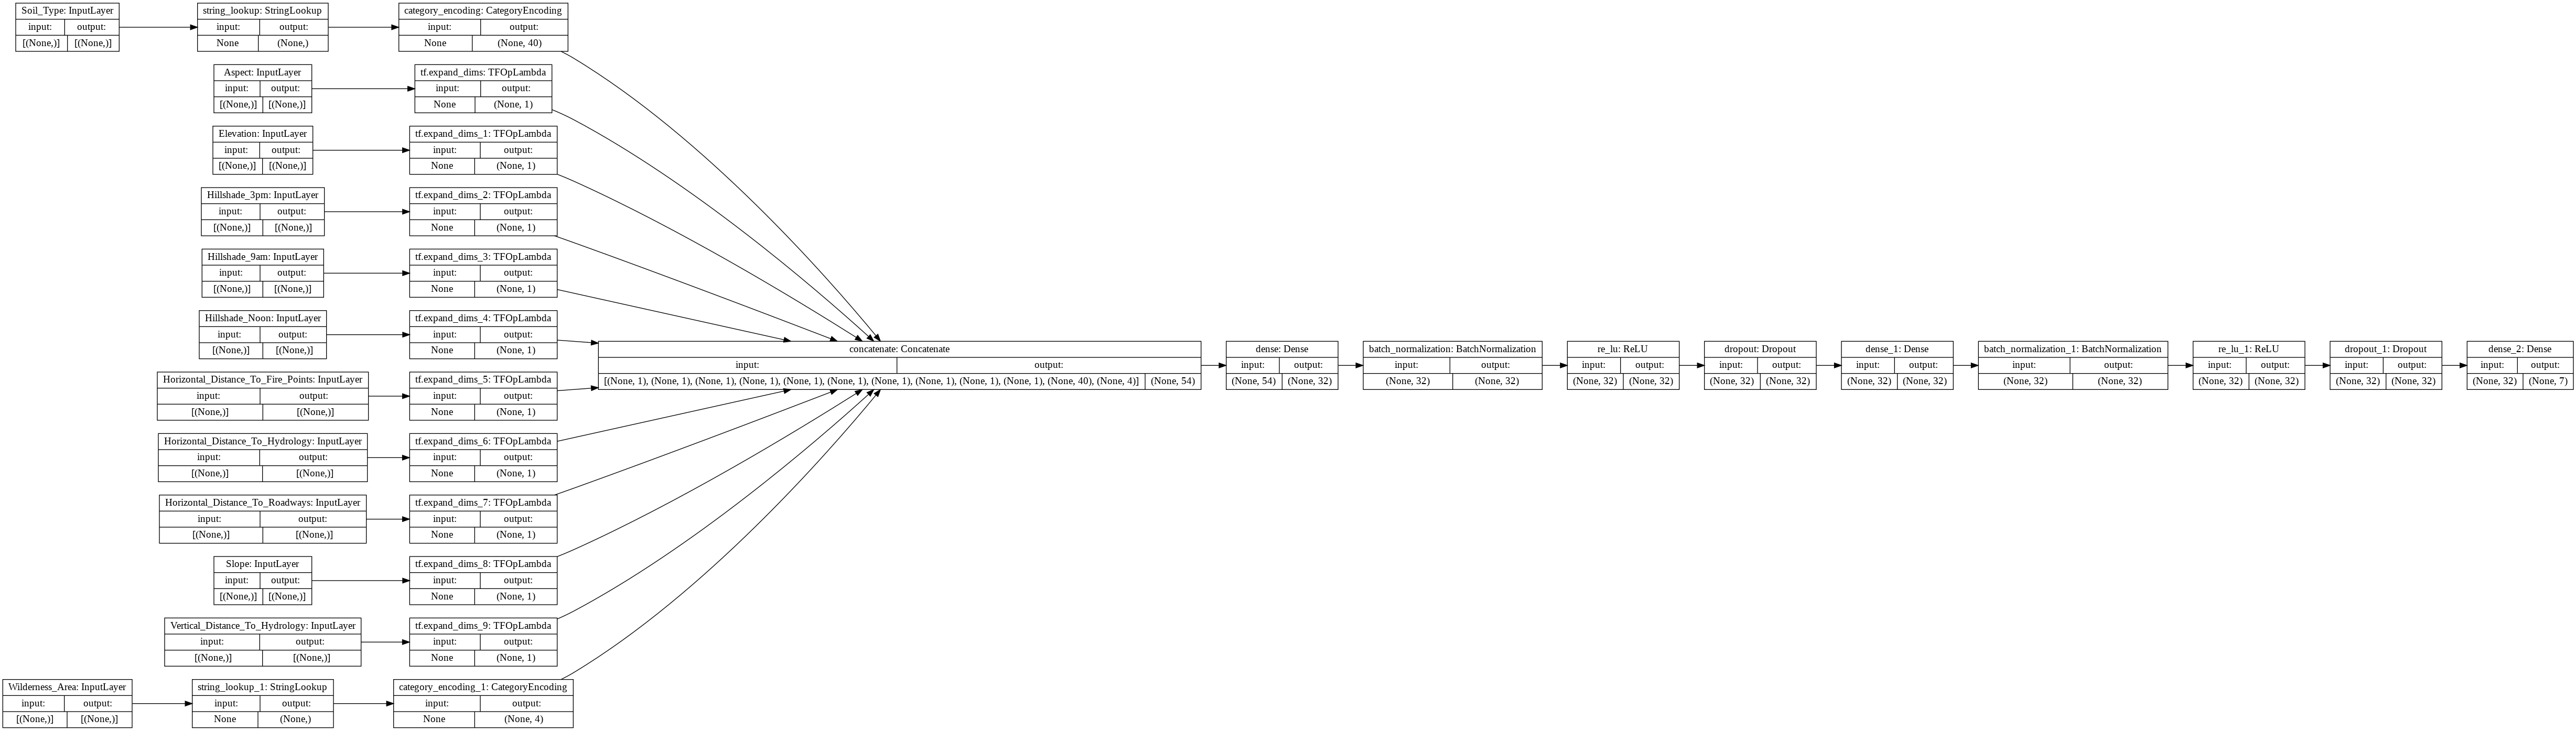

In [ ]:

def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    # hidden_units is (32, 32)
    # we pass the features from one layer to the next, applying normalisations, activations and dropout after passing it through the 
    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

Let's run it:

In [ ]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1865/1865 [==============================] - 17s 9ms/step - loss: 0.9842 - sparse_categorical_accuracy: 0.6144
Epoch 2/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.7101
Epoch 3/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.6456 - sparse_categorical_accuracy: 0.7222
Epoch 4/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7296
Epoch 5/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.6115 - sparse_categorical_accuracy: 0.7379
Epoch 6/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.6009 - sparse_categorical_accuracy: 0.7418
Epoch 7/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.5937 - sparse_categorical_accuracy: 0.7447
Epoch 8/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.5885 - sparse_categorical_accuracy: 0.7466
Epo

The baseline linear model achieves ~76% test accuracy.

### Experiment 2: Wide & Deep model

In the second experiment, we create a Wide & Deep model. The wide part of the model
a linear model, while the deep part of the model is a multi-layer feed-forward network.

Use the sparse representation of the input features in the wide part of the model and the
dense representation of the input features for the deep part of the model.

Note that every input features contributes to both parts of the model with different
representations. You can see that we merge the layers near the end before reaching the output of the model. 

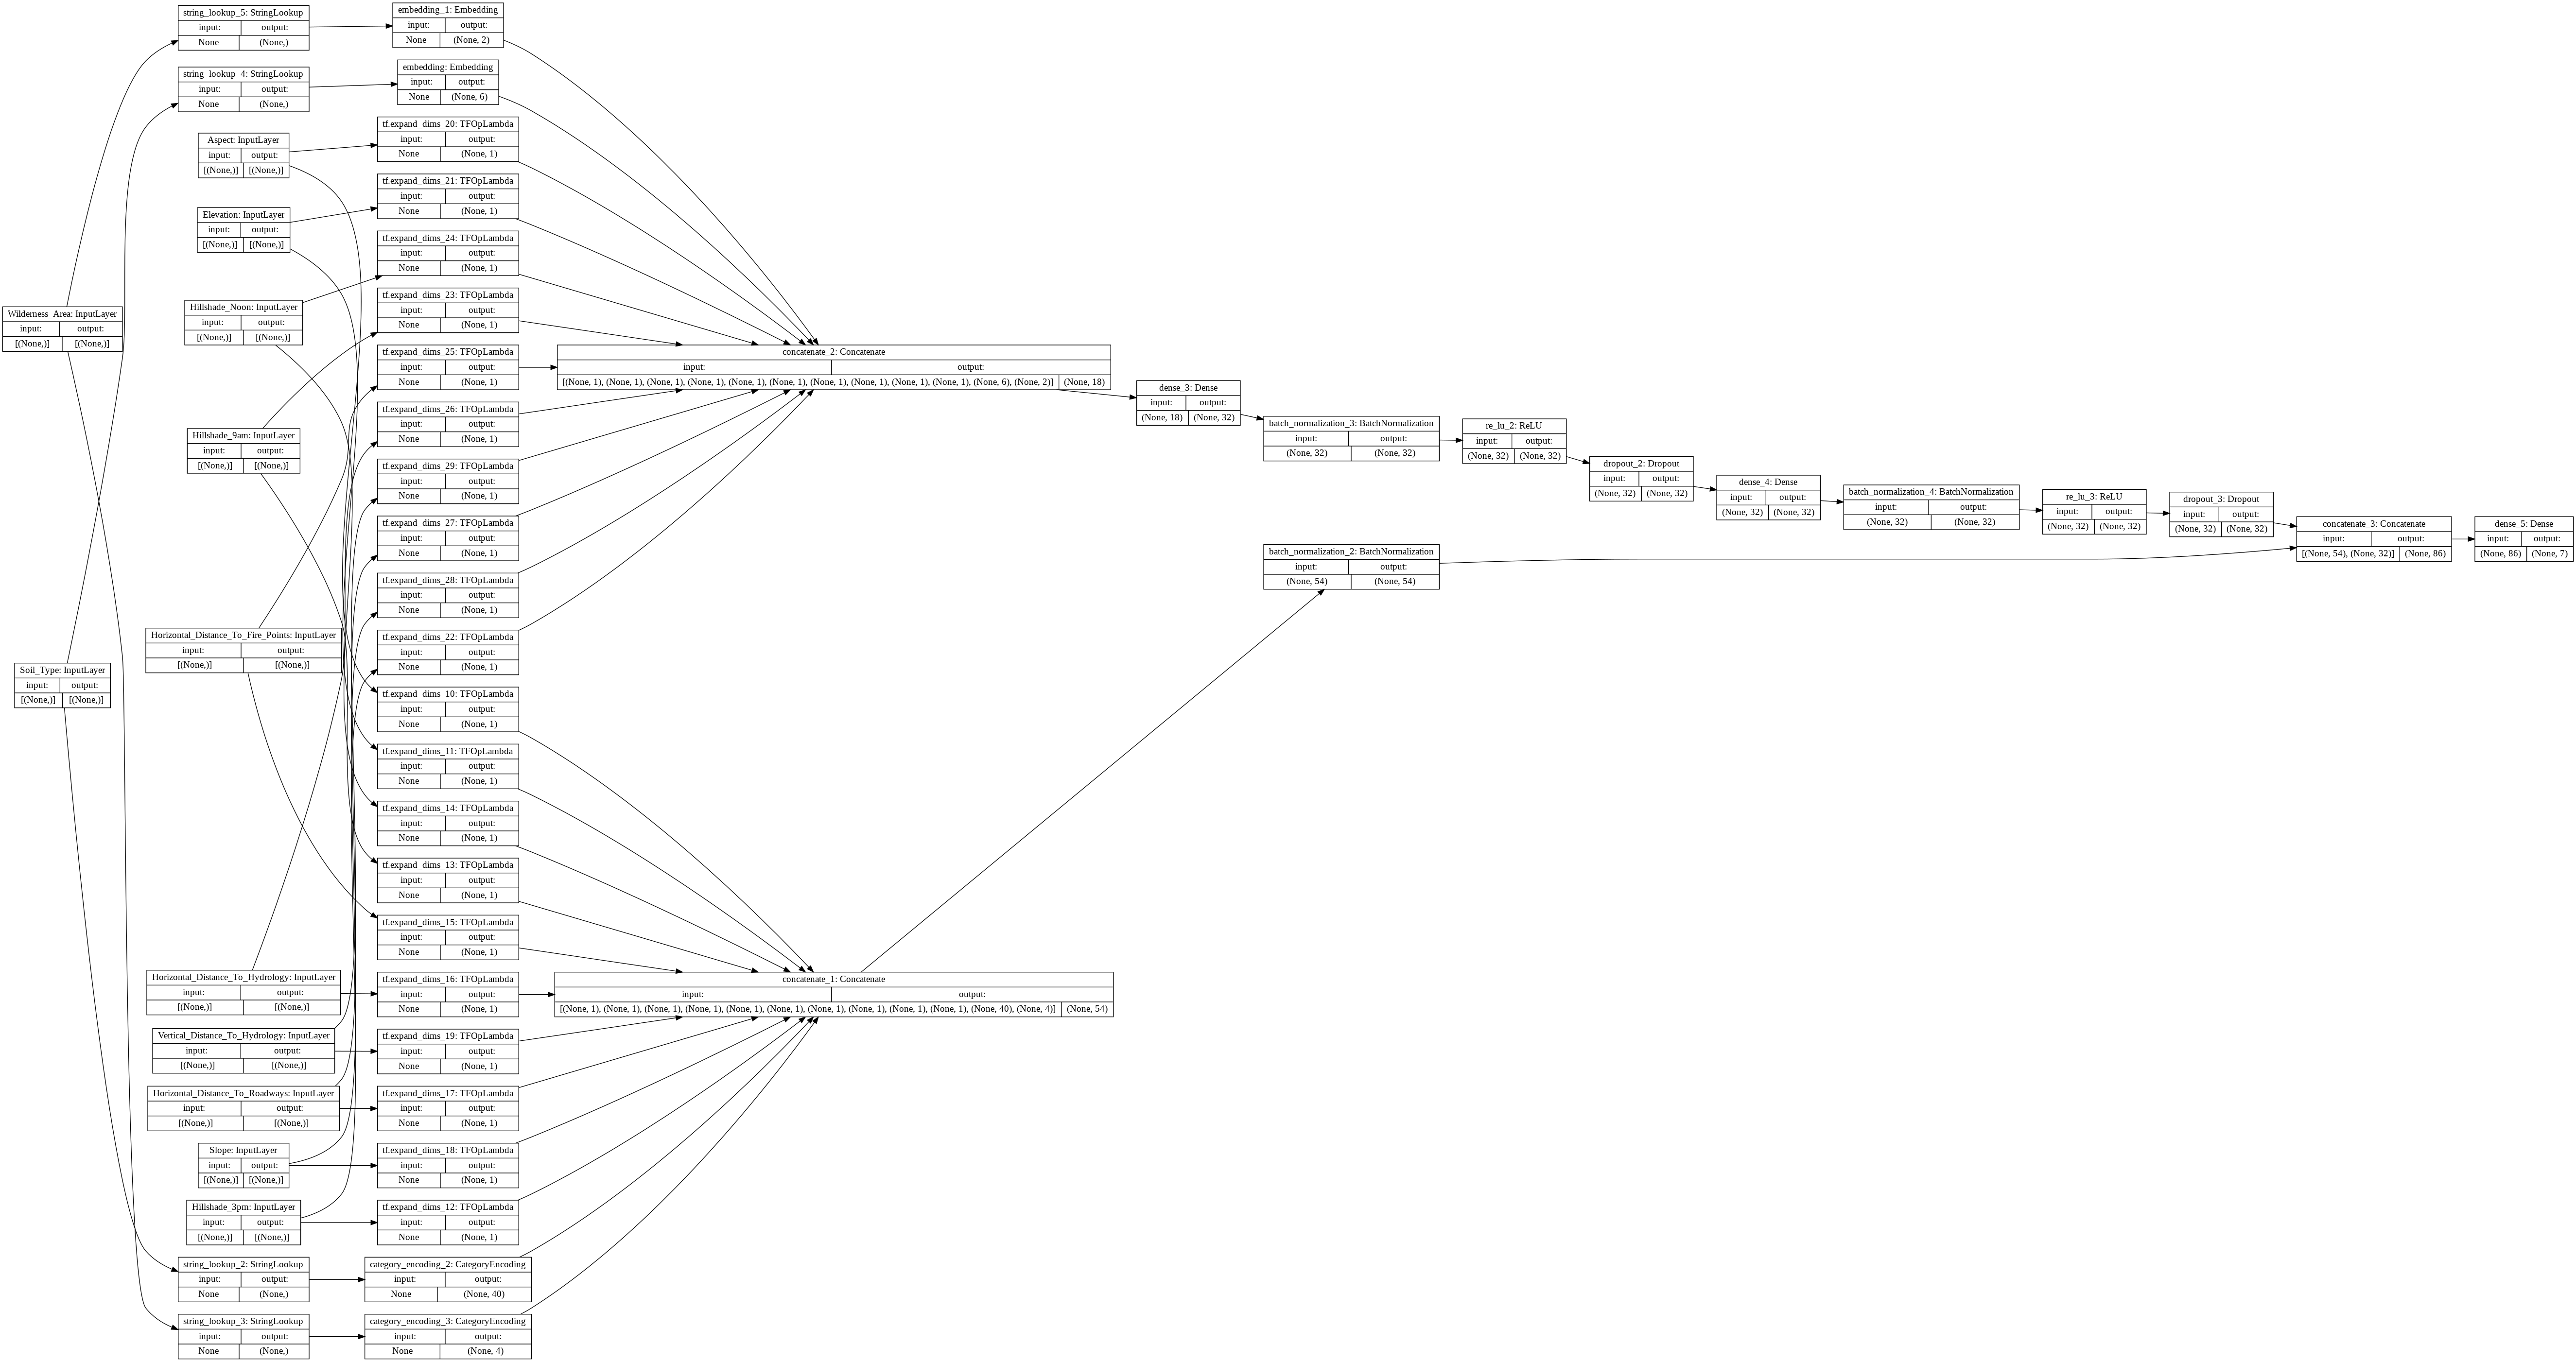

In [ ]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

Let's run it:

In [ ]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1865/1865 [==============================] - 15s 7ms/step - loss: 0.8842 - sparse_categorical_accuracy: 0.6474
Epoch 2/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.6110 - sparse_categorical_accuracy: 0.7352
Epoch 3/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.5921 - sparse_categorical_accuracy: 0.7430
Epoch 4/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.5807 - sparse_categorical_accuracy: 0.7474
Epoch 5/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.5714 - sparse_categorical_accuracy: 0.7520
Epoch 6/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.5636 - sparse_categorical_accuracy: 0.7555
Epoch 7/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.5563 - sparse_categorical_accuracy: 0.7595
Epoch 8/50
1865/1865 [==============================] - 7s 4ms/step - loss: 0.5512 - sparse_categorical_accuracy: 0.7623
Epo

The wide and deep model achieves ~79% test accuracy.

### Experiment 3: Deep & Cross model

In the third experiment, we create a Deep & Cross model. The deep part of this model
is the same as the deep part created in the previous experiment. The key idea of
the cross part is to apply explicit feature crossing in an efficient way,
where the degree of cross features grows with layer depth.

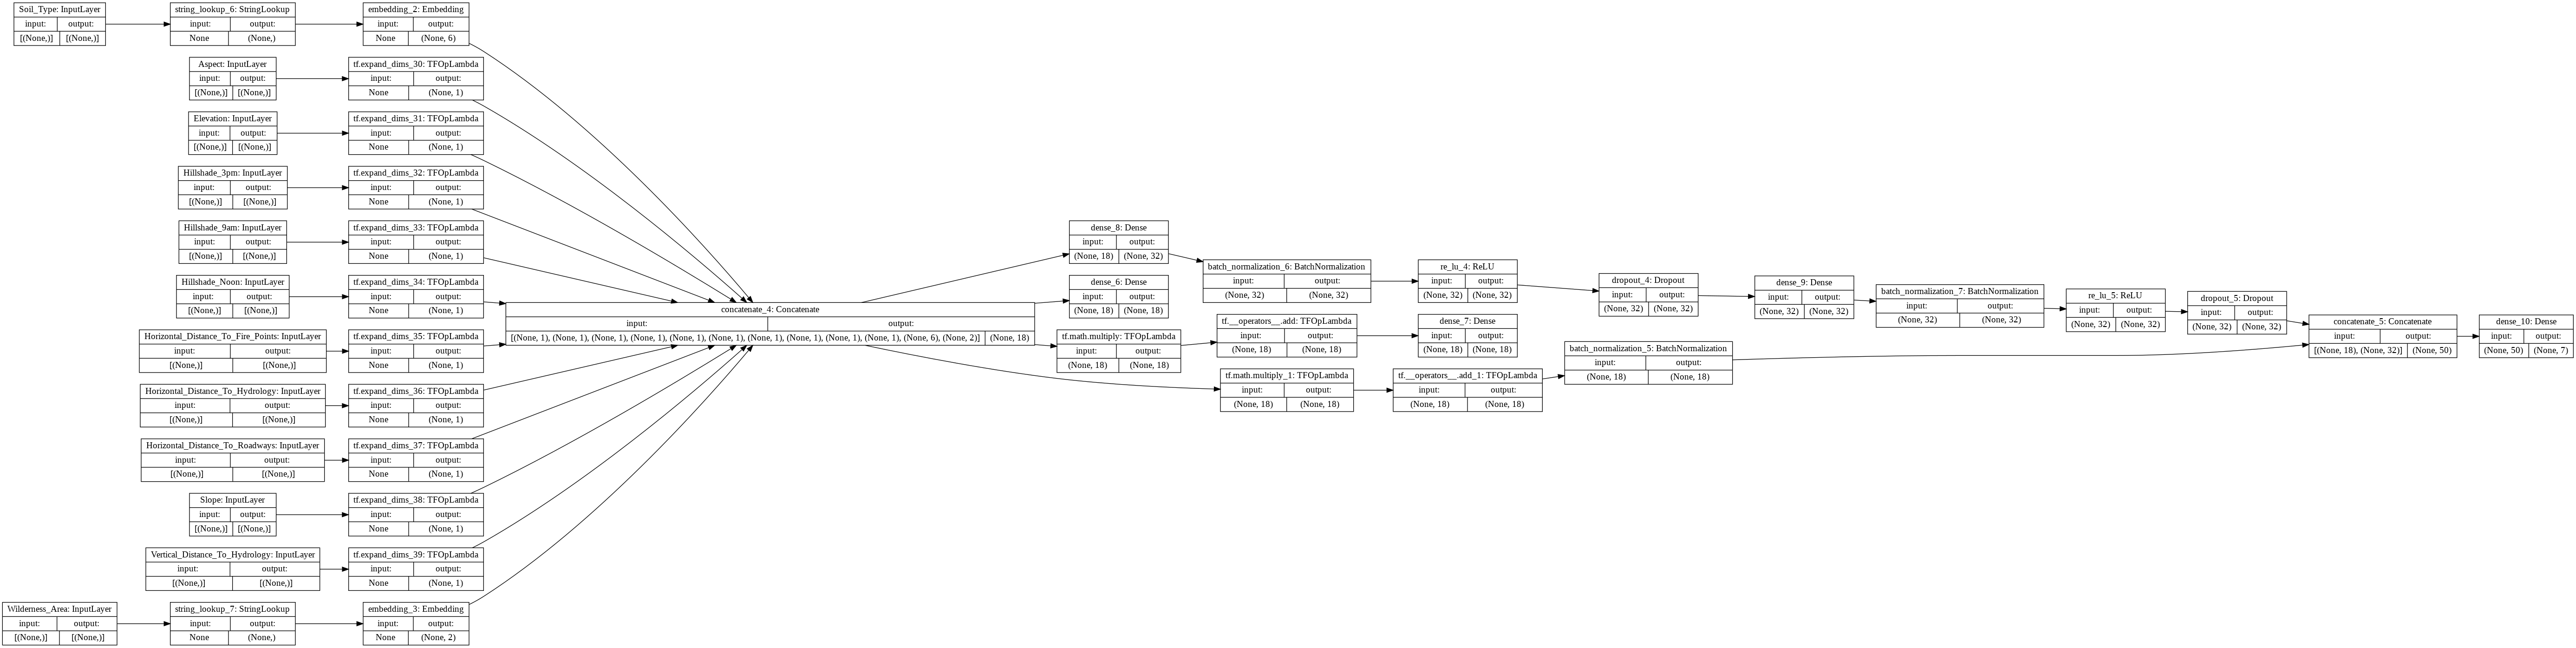

In [ ]:

def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

Let's run it:

In [ ]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1865/1865 [==============================] - 19s 9ms/step - loss: 0.8569 - sparse_categorical_accuracy: 0.6534
Epoch 2/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.5954 - sparse_categorical_accuracy: 0.7429
Epoch 3/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.5753 - sparse_categorical_accuracy: 0.7503
Epoch 4/50
1865/1865 [==============================] - 8s 5ms/step - loss: 0.5638 - sparse_categorical_accuracy: 0.7550
Epoch 5/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.5556 - sparse_categorical_accuracy: 0.7592
Epoch 6/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.5504 - sparse_categorical_accuracy: 0.7615
Epoch 7/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.5454 - sparse_categorical_accuracy: 0.7639
Epoch 8/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.5413 - sparse_categorical_accuracy: 0.7646
Epo

The deep and cross model achieves ~81% test accuracy.

### Using the Model for Feature Extraction

Keras models allow you to create a feature extraction version of the model. See [this tutorial](https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction) for more reasons. Basically, by feeding in model inputs and outputs as just the layer you want to receive the features for, we create a model that can extract any layer we want. In the code below we get one big batch of data from the test, and then pick up the very first datapoint to serve as test to extract features. 

In [ ]:
# repurpose our dataloading code for one sample
sample = get_dataset_from_csv(test_data_file, 1)

In [ ]:
# iterate through the dataset and pick up what point you want. We just pick up the first and then break
for data in sample.as_numpy_iterator():
  data_point = data
  break

In [ ]:
# look at the data
dict(data_point[0])


{'Aspect': array([193], dtype=int32),
 'Elevation': array([3014], dtype=int32),
 'Hillshade_3pm': array([164], dtype=int32),
 'Hillshade_9am': array([217], dtype=int32),
 'Hillshade_Noon': array([251], dtype=int32),
 'Horizontal_Distance_To_Fire_Points': array([1113], dtype=int32),
 'Horizontal_Distance_To_Hydrology': array([503], dtype=int32),
 'Horizontal_Distance_To_Roadways': array([5399], dtype=int32),
 'Slope': array([16], dtype=int32),
 'Soil_Type': array([b'soil_type_30'], dtype=object),
 'Vertical_Distance_To_Hydrology': array([124], dtype=int32),
 'Wilderness_Area': array([b'area_type_1'], dtype=object)}

In [ ]:
# create a version of the model to extract the second last layer because the one below that will just be a probability distribution for the classes
extractor_second_last_layer = keras.Model(inputs=deep_and_cross_model.inputs,
                        outputs=[deep_and_cross_model.layers[-2].output])

In [ ]:
extractor_last_layer = keras.Model(inputs=deep_and_cross_model.inputs,
                        outputs=[deep_and_cross_model.layers[-1].output])

In [ ]:
# create a version of the model to extract all layers
extractor = keras.Model(inputs=deep_and_cross_model.inputs,
                        outputs=[layer.output for layer in deep_and_cross_model.layers])

Pass our data through the second last layer extractor. We see a numpy array representing the layer after having passed the data!

In [ ]:
extractor_second_last_layer(dict(data_point[0]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 1.3944237 , -0.04802036, -2.6881928 , -1.8890533 , -0.83321786,
         0.9746413 ,  1.4299227 , -1.2381314 , -1.2522163 , -1.7503781 ,
         0.8591982 ,  0.88812184, -0.3033852 , -0.94212663,  1.3438756 ,
         0.6180281 , -0.11245668,  0.52136225,  0.        ,  0.        ,
         2.0602756 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.6767266 ,
         0.        ,  0.15299182,  0.        ,  0.4099776 ,  1.9824297 ,
         2.394533  ,  0.        ,  1.2556915 ,  0.        ,  0.82477915,
         0.        ,  0.        ,  0.        ,  0.21563125,  0.        ,
         0.        ,  0.5924037 ,  0.        ,  0.        ,  3.5000358 ]],
      dtype=float32)>

We'd expect this layer to be just a distribution of the probabilities of it belonging to each class.

In [ ]:
extractor_last_layer(dict(data_point[0]))

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[2.20672903e-03, 9.97789264e-01, 5.84493454e-10, 9.20603603e-15,
        3.91926051e-06, 1.13529836e-07, 1.80949034e-08]], dtype=float32)>

Simlarly, we can extract any layer which we find useful. We can expect these layers to have useful information to do with identifying forest covers embedded in them,

### Conclusion

You can use Keras Preprocessing Layers to easily handle categorical features
with different encoding mechanisms, including one-hot encoding and feature embedding.
In addition, different model architectures — like wide, deep, and cross networks
— have different advantages, with respect to different dataset properties.
You can explore using them independently or combining them to achieve the best result
for your dataset.

# Categorical and Tabular Embeddings

[Table2Vec: Neural Word and Entity Embeddings for Table Population and Retrieval](https://arxiv.org/abs/1906.0004)

[GitHub Table2vec](https://github.com/ninalx/table2vec-lideng)


Deep embedding’s for categorical variables (Cat2Vec) - [Gitlab code](https://gitlab.com/praj88/deepembeddings/-/blob/master/Scripts/deepEmbeddings_Keras.ipynb)

Categorical Embeddings - [fastai](https://www.fast.ai/2018/04/29/categorical-embeddings/)

https://github.com/fastai/fastai

[tut_1](https://github.com/fastai/fastai/blob/master/nbs/41_tabular.data.ipynb)

[tut_2](https://github.com/fastai/fastai/blob/master/nbs/42_tabular.model.ipynb)

[tut_3](https://github.com/fastai/fastai/blob/master/nbs/43_tabular.learner.ipynb)


Finally, we can turn tables into representations. These have become most popular in the context of collaborative filtering, where a sparse table of associations between persons and products/songs/movies is embedded, which discovers associations between persons (rows) and elements (columns) for preference prediction. Dense tables can also be embedded to facilitate information search.
 
https://keras.io/examples/keras_recipes/memory_efficient_embeddings/

# TaBERT

Table BERT, and other joint models.
https://github.com/facebookresearch/TaBERT

# Knowledge Graph Embeddings


https://mnick.github.io/project/knowledge-graph-embeddings/

kgetorch - https://github.com/torchkge-team/torchkge

pykg2vec - https://github.com/Sujit-O/pykg2vec

transE - https://github.com/ZichaoHuang/TransE

transE + KGE - https://github.com/Lapis-Hong/TransE-Knowledge-Graph-Embedding

https://github.com/bakerwho/weboftruth/blob/master/weboftruth/utils.pyZ

# Homework

In this homework you will be using your tabular/categorical data, and knowledge graphs, if possible, and run deep learning models on them.

**1)** Find and load a tabular or categorical dataset of your choice.

**2)** Use the wide and deep model or the deep and cross model to perform a classification task on your data. Also extract features from your model and visualise it.

**3)** Use any categorical or tabular embedding method on your data.

**4)** Create a knowledge graph dataset relevant to your social science interest.

**5)** Run a knowledge graph embedding algorithm on your dataset. Visualise your embeddings and run distance metrics on them.